In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

import torch
import os
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Cloning into 'yolov5'...
remote: Enumerating objects: 16559, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 16559 (delta 18), reused 29 (delta 13), pack-reused 16522
Receiving objects: 100% (16559/16559), 15.06 MiB | 16.73 MiB/s, done.
Resolving deltas: 100% (11371/11371), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/v7.0" to /root/.cache/torch/hub/v7.0.zip
requirements: YOLOv5 requirements "gitpython" "ipython" "torch>=1.7.0" "torchvision>=0.8.1" not found, attempting AutoUpdate...
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-many

give path to an input image :/content/drive/MyDrive/train_data/train_data/images/train/P0001_0_800_7200_8000.jpg


WARNING ⚠️ NMS time limit 0.550s exceeded


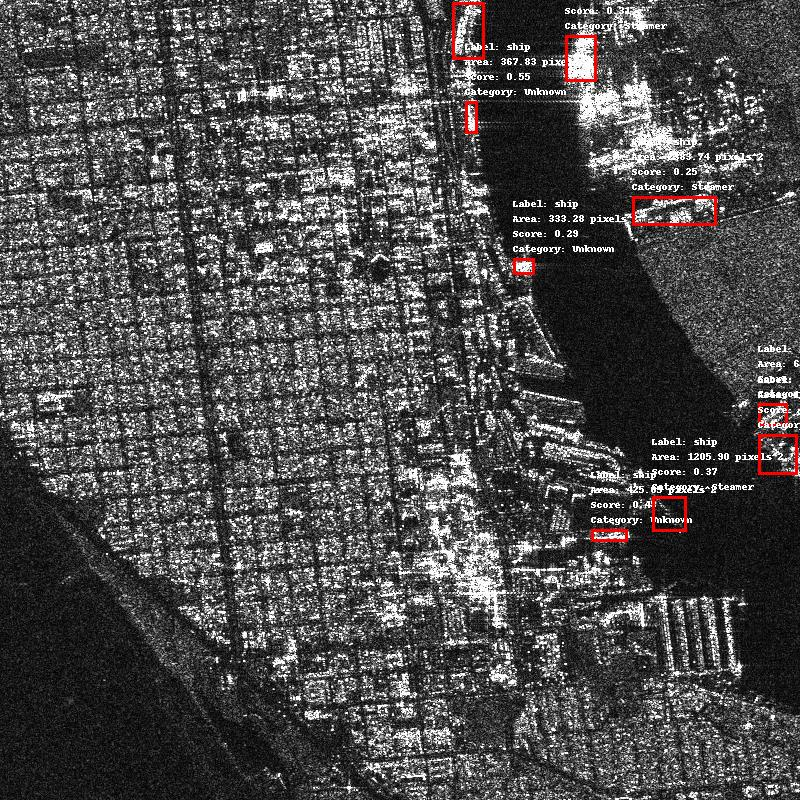

In [1]:
import torch
from PIL import Image, ImageDraw
from IPython.display import display, Image as IPImage

# Load your custom-trained YOLOv5 model
model = torch.hub.load('ultralytics/yolov5:v7.0', 'custom', path='/content/drive/MyDrive/yolov5/ship_det.pt')

# Path to the SAR image
sar_image_path = input("give path to an input image :")

# Run inference
results = model(sar_image_path)

# Extract bounding box coordinates
bounding_boxes = results.xyxy[0].cpu().numpy()  # xyxy format (xmin, ymin, xmax, ymax, conf, class)

# Load the SAR image
sar_image = Image.open(sar_image_path)

# Create a drawing object
draw = ImageDraw.Draw(sar_image)

# Define area thresholds for ship categories (adjust as needed)
ship_type_thresholds = {
    'Steamer': (1000, 5000),
    'Boat': (500, 1000),
    'Container Ships': (5000, 10000),
    'Aircraft Carrier': (15000, 30000),
    # Add more ship types with their corresponding area thresholds
}

# Function to categorize a ship based on its area
def categorize_ship(area):
    for ship_type, thresholds in ship_type_thresholds.items():
        if thresholds[0] <= area < thresholds[1]:
            return ship_type
    return 'Unknown'

# Calculate and display the area, objectiveness score, label, and category within each bounding box
for box in bounding_boxes:
    x_min, y_min, x_max, y_max, conf, class_idx = box
    class_name = model.names[int(class_idx)]

    # Calculate the area of the ship
    area = (x_max - x_min) * (y_max - y_min)

    # Categorize the ship based on the area
    ship_category = categorize_ship(area)

    # Draw bounding box
    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

    # Display area, objectiveness score, label, and category directly on the image
    info_text = f"Label: {class_name}\nArea: {area:.2f} pixels^2\nScore: {conf:.2f}\nCategory: {ship_category}"
    text_position = (x_min, y_min - 60)  # Adjust the position as needed
    draw.text(text_position, info_text, fill="white")

# Save the image with bounding boxes, area, objectiveness score, label, and category
image_with_info_path = '/content/drive/MyDrive/train_data/train_data/images/train/P0001_0_800_7200_8000.jpg'
sar_image.save(image_with_info_path)

# Display the image with bounding boxes, area, objectiveness score, label, and category using IPython display
display(IPImage(filename=image_with_info_path))


In [ ]:

!python segment/predict.py --weights /content/drive/MyDrive/yolov5/oilspill_det.pt --source /content/oil/images/train/img_0012.jpg

segment/predict: weights=['/content/drive/MyDrive/yolov5/oilspill_det.pt'], source=/content/oil/images/train/img_0012.jpg, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/predict-seg, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1, retina_masks=False
YOLOv5 🚀 v7.0-303-gcf8b67b7 Python-3.10.12 torch-2.2.1+cu121 CPU

Fusing layers... 
Model summary: 165 layers, 7398422 parameters, 0 gradients, 25.7 GFLOPs
image 1/1 /content/oil/images/train/img_0012.jpg: 352x640 1 oilspill, 342.8ms
Speed: 2.2ms pre-process, 342.8ms inference, 24.7ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/predict-seg/exp2


In [ ]:
!unzip /content/drive/MyDrive/oil.zip -d /content/oil

Archive:  /content/drive/MyDrive/oil.zip
   creating: /content/oil/.ipynb_checkpoints/
   creating: /content/oil/images/
   creating: /content/oil/labels/
   creating: /content/oil/labels/.ipynb_checkpoints/
   creating: /content/oil/labels/train/
   creating: /content/oil/labels/val/
  inflating: /content/oil/labels/train.cache  
  inflating: /content/oil/labels/val.cache  
  inflating: /content/oil/labels/train/img_0032.txt  
  inflating: /content/oil/labels/train/img_0029.txt  
  inflating: /content/oil/labels/train/img_0003.txt  
  inflating: /content/oil/labels/train/img_0035.txt  
  inflating: /content/oil/labels/train/img_0001.txt  
  inflating: /content/oil/labels/train/img_0036.txt  
  inflating: /content/oil/labels/train/img_0034.txt  
  inflating: /content/oil/labels/train/img_0013.txt  
  inflating: /content/oil/labels/train/img_0023.txt  
  inflating: /content/oil/labels/train/img_0019.txt  
  inflating: /content/oil/labels/train/img_0028.txt  
  inflating: /content/oil/la